In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import sys
from scipy.special import jn
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import scipy.special as sps

from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist, ProbDistContainer
from functools import partial

#=== 5PN AAK imports ================

from few.trajectory.inspiral import EMRIInspiral
#from few.waveform import Pn5AAKWaveform # we don't need waveform generation
#from few.utils.utility import get_fundamental_frequencies


sys.path.append(os.path.abspath('../KerrOrbitalAngleConversion/build/lib.macosx-11.0-arm64-cpython-313/'))

# Constants
G = 6.674080e-11 #Gravitational constant in SI
c = 299792458. #speed of light in SI
MSUN = 1.98848e30 #Mass of sun in SI
YRSID = 31558149.763545603 #seconds in one year 

# Functions

In [15]:
def Radial_Coordinate(p, e, Phi_r):
    return p/(1 + e * np.cos(Phi_r))

def Polar_Coordinate(x, Phi_theta):
    return np.arccos(np.sqrt(1-x**2)*np.cos(Phi_theta))
    #return np.arccos(x*np.cos(Phi_theta))

def sph2cart(r,theta,phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x,y,z

def bl2kep2(t,a,p,e,x,Phi_r, Phi_theta, Phi_phi):
    rr = Radial_Coordinate(p, e, Phi_r)
    tt = Polar_Coordinate(x, Phi_theta)
    return [t, *sph2cart(rr,tt,Phi_phi)]

def bl2kep(t, a, p, e, x, Phi_r, Phi_theta, Phi_phi):
    # Using https://arxiv.org/abs/2411.04955
    bl_angles=[]
    for i in np.arange(1,len(t)): #skipping the first, it always gives nan...
        AA = kac.pyBoyerLindquistPhasesToDarwinPhases(a,p[i],e[i],x[i],Phi_r[i],Phi_theta[i],Phi_phi[i])
        if np.any(np.isnan(AA)):
            print("ALERT! Proper BoyerLidquist2Darwin failed, using less accurate version!!!")
            return bl2kep2(t,a,p,e,x,Phi_r, Phi_theta, Phi_phi)
        else:
            bl_angles.append(AA)
    psi_from_AA,chi_from_AA,phi_from_AA = np.array(bl_angles).T
    tt = t[1:len(bl_angles)+1]
    pp = p[1:len(bl_angles)+1]
    ee = e[1:len(bl_angles)+1]
    xx = x[1:len(bl_angles)+1]
    r_from_AA = Radial_Coordinate(pp, ee, psi_from_AA)
    theta_from_AA = Polar_Coordinate(xx, chi_from_AA)
    x_coord_from_AA, y_coord_from_AA, z_coord_from_AA = sph2cart(r_from_AA ,theta_from_AA, phi_from_AA)
    trajectory = [tt,x_coord_from_AA,y_coord_from_AA,z_coord_from_AA]
    return trajectory

def Keplerian_p_from_f(M, mu, f_orb_0, e0):
    return c**2*(1-e0**2)/(2*np.pi*f_orb_0*G*(M+mu)*MSUN)**(2/3)

def intersect_trajectory_with_disk(trajectory, disk_center, disk_normal, disk_radius):
    intersections = []
    disk_normal = np.array(disk_normal) / np.linalg.norm(disk_normal)  # Ensure unit normal
    disk_center = np.array(disk_center)
    trajectory = np.array(trajectory).T
    for i in range(len(trajectory) - 1):
        p1, p2 = np.array(trajectory[i]), np.array(trajectory[i + 1])
        segment = p2 - p1
        denom = np.dot(segment[1:], disk_normal)
        if np.isclose(denom, 0, atol=1e-8):
            print("Segment is parallel to the disk plane, skipping!") # Should be better about this!!!
            continue  
        t = np.dot(disk_center - p1[1:], disk_normal) / denom
        if 0 <= t <= 1:
            intersection = p1 + t * segment
            if np.linalg.norm(intersection[1:] - disk_center) <= disk_radius:
                intersections.append(intersection.tolist())
    
    return np.array(intersections)

def intersect_trajectory_with_rotating_disk(trajectory, disk_center0, disk_normal0, disk_radius, omega, tol=1e-8, max_iter=50, num_samples=200):
    """
    Finds intersections between a trajectory and a disk that rotates about the z-axis 
    with angular frequency omega.
    
    The disk is defined in its body frame (time zero) by:
      - disk_center0: center (3-vector)
      - disk_normal0: unit normal (3-vector)
      - disk_radius: scalar radius
      
    At time t the disk is rotated in the inertial frame as:
      disk_center(t) = Rz(omega*t) @ disk_center0
      disk_normal(t) = Rz(omega*t) @ disk_normal0
      
    A trajectory point p=(t,x,y,z) lies in the disk plane at time t if, after rotating by -omega*t,
    its spatial part p_body satisfies:
      (p_body - disk_center0) · disk_normal0 = 0.
    
    For non-coplanar segments (i.e. crossing the plane) a bisection routine is used to locate the unique crossing.
    If a segment is (nearly) coplanar, then the entire segment lies in the disk plane, and we search
    for intersections of the segment with the disk’s circular boundary.
    
    Parameters:
      trajectory: list or tuple of 4 array-like objects [t, x, y, z] (each with shape (N,)).
      disk_center0: array-like, initial center of the disk (3-vector).
      disk_normal0: array-like, initial normal of the disk (3-vector; will be normalized).
      disk_radius: scalar, radius of the disk.
      omega: angular frequency of the disk's rotation about the z-axis.
      tol: tolerance for root finding.
      max_iter: maximum iterations for bisection.
      num_samples: number of samples used in the coplanar case.
      
    Returns:
      intersections: np.array of intersection points (each is (t,x,y,z)).
    """
    intersections = []
    disk_normal0 = np.array(disk_normal0, dtype=float)
    disk_normal0 /= np.linalg.norm(disk_normal0)
    disk_center0 = np.array(disk_center0, dtype=float)

    # Expect trajectory to be [t array, x array, y array, z array].
    if len(trajectory) != 4:
        raise ValueError("Trajectory must be a list of 4 arrays: [t, x, y, z].")
    traj = np.column_stack(trajectory)

    # Inline rotation: computes Rz(-omega*tau)*pos for a spatial 3-vector.
    def rotate_z_neg(angle, pos):
        c = np.cos(angle)
        s = np.sin(angle)
        return np.array([c * pos[0] + s * pos[1],
                         -s * pos[0] + c * pos[1],
                         pos[2]])

    # Process each segment.
    for i in range(len(traj) - 1):
        p1 = traj[i]
        p2 = traj[i + 1]
        dt = p2[0] - p1[0]
        if dt == 0:
            continue  # Skip segments with zero time difference

        pos_diff = p2[1:] - p1[1:]
        t_diff = dt

        # f(lam) measures how far the rotated spatial point is from the disk plane.
        def f(lam):
            tau = p1[0] + lam * t_diff
            pos = p1[1:] + lam * pos_diff
            pos_body = rotate_z_neg(omega * tau, pos)
            return np.dot(pos_body - disk_center0, disk_normal0)
        
        f0 = f(0.0)
        f1 = f(1.0)

        # Check if the segment is nearly coplanar with the disk.
        if np.abs(f0) < tol and np.abs(f1) < tol:
            # Define g(lam): distance from disk center (in body frame) minus disk_radius.
            def g(lam):
                tau = p1[0] + lam * t_diff
                pos = p1[1:] + lam * pos_diff
                pos_body = rotate_z_neg(omega * tau, pos)
                return np.linalg.norm(pos_body - disk_center0) - disk_radius

            # Sample g(lam) over the segment.
            lam_vals = np.linspace(0, 1, num_samples)
            g_vals = np.array([g(lam) for lam in lam_vals])

            # Look for sign changes or near-zero values.
            for j in range(len(lam_vals) - 1):
                if np.abs(g_vals[j]) < tol:
                    lam_root = lam_vals[j]
                elif g_vals[j] * g_vals[j+1] < 0:
                    lam_low = lam_vals[j]
                    lam_high = lam_vals[j+1]
                    g_low = g_vals[j]
                    for _ in range(max_iter):
                        lam_mid = (lam_low + lam_high) / 2.0
                        g_mid = g(lam_mid)
                        if np.abs(g_mid) < tol:
                            break
                        if g_low * g_mid < 0:
                            lam_high = lam_mid
                        else:
                            lam_low = lam_mid
                            g_low = g_mid
                    lam_root = (lam_low + lam_high) / 2.0
                else:
                    continue
                tau_sol = p1[0] + lam_root * t_diff
                pos_sol = p1[1:] + lam_root * pos_diff
                intersection = np.hstack(([tau_sol], pos_sol))
                if not any(np.allclose(intersection, x, atol=tol) for x in intersections):
                    intersections.append(intersection)
            continue

        # For non-coplanar segments, check endpoints and then use bisection.
        if np.abs(f0) < tol:
            lam_sol = 0.0
        elif np.abs(f1) < tol:
            lam_sol = 1.0
        elif f0 * f1 > 0:
            continue  # No crossing.
        else:
            lam_low = 0.0
            lam_high = 1.0
            f_low = f0
            lam_sol = None
            for _ in range(max_iter):
                lam_mid = (lam_low + lam_high) / 2.0
                f_mid = f(lam_mid)
                if np.abs(f_mid) < tol:
                    lam_sol = lam_mid
                    break
                if f_low * f_mid < 0:
                    lam_high = lam_mid
                else:
                    lam_low = lam_mid
                    f_low = f_mid
            if lam_sol is None:
                lam_sol = (lam_low + lam_high) / 2.0

        if lam_sol < 0 or lam_sol > 1:
            continue

        tau_sol = p1[0] + lam_sol * t_diff
        pos_sol = p1[1:] + lam_sol * pos_diff
        pos_body = rotate_z_neg(omega * tau_sol, pos_sol)
        if np.linalg.norm(pos_body - disk_center0) <= disk_radius:
            intersection = np.hstack(([tau_sol], pos_sol))
            intersections.append(intersection)

    return np.vstack(intersections) if intersections else np.array([])


def plot_inclined_disk(ax, center, radius, normal, num_points=100, color='red', alpha=0.3):
    """
    Plots a transparent disk in 3D, oriented according to the given normal vector.
    
    Parameters:
      ax        : The 3D axes to plot on.
      center    : Tuple (x, y, z) for the disk center.
      radius    : Radius of the disk.
      normal    : The desired normal vector (as an array-like of 3 numbers).
      num_points: Number of points used to sample the circle.
      color     : Disk color.
      alpha     : Transparency (0 is fully transparent, 1 is opaque).
    """
    # Create a circle in the xy-plane (z = 0)
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    z = np.zeros_like(x)
    points = np.vstack((x, y, z))  # shape: (3, num_points)
    
    # Normalize the input normal vector
    normal = np.array(normal, dtype=float)
    normal /= np.linalg.norm(normal)
    
    # The default disk normal is along the z-axis
    z_axis = np.array([0, 0, 1])
    
    # Compute the rotation axis (cross product) and angle (via dot product)
    v = np.cross(z_axis, normal)
    s = np.linalg.norm(v)
    c = np.dot(z_axis, normal)
    # If s is close to zero, the normals are parallel.
    if np.isclose(s, 0):
        if c < 0:
            # 180 degree rotation: flip x and y.
            R = np.array([[-1,  0,  0],
                          [ 0, -1,  0],
                          [ 0,  0,  1]])
        else:
            R = np.eye(3)
    else:
        # Rodrigues' rotation formula components
        vx = np.array([[0, -v[2], v[1]],
                       [v[2], 0, -v[0]],
                       [-v[1], v[0], 0]])
        R = np.eye(3) + vx + np.dot(vx, vx) * ((1 - c) / (s**2))
    
    # Rotate the circle points
    points_rot = R.dot(points)
    
    # Translate points to the specified center
    points_rot[0, :] += center[0]
    points_rot[1, :] += center[1]
    points_rot[2, :] += center[2]
    
    # Create a 3D polygon from the points and add it to the axes
    poly = Poly3DCollection([points_rot.T], color=color, alpha=alpha,edgecolors='none')
    ax.add_collection3d(poly)

def gaussian_peaks(t, crossing_times, width=0.05):
    """
    Generates a sum of Gaussian peaks centered at given crossing times.

    Parameters:
    t : array-like
        Time values for evaluation.
    crossing_times : list or array
        List of times where Gaussians should peak.
    width : float
        Standard deviation of the Gaussians (controls peak width).

    Returns:
    array:
        Sum of Gaussian peaks evaluated at t.
    """
    t = np.asarray(t)
    result = np.zeros_like(t)

    for crossing in crossing_times:
        result += np.exp(-((t - crossing) ** 2) / (2 * width ** 2)) #* np.exp(1j * width * (t - crossing)).real

    return result

def generate_template(x1, x2, x3, x4, dt=20):
    # System Parameters
    M = x1
    m = x2
    f1_measured = x3  #0.0007380463140752472
    e0 = x4   #0.22865665220266215
    a = 0.0
    p0 = Keplerian_p_from_f(M, m, f1_measured, e0)
    iota0 = 0.0
    #iota0 = 0.001
    Y0 = np.cos(iota0)
    Phi_phi0 = 0.
    Phi_theta0 = 1.2
    Phi_r0 = 3.5

    # Extrinsic params
    qS = 0.2
    phiS = 0.2
    qK = 0.8
    phiK = 0.8
    dist = 5.235888314207546
    mich = False
    dt = dt
    T = 0.001

    # Disk Params
    disk_center0 = [0.0, 0.0, 0.0]
    disk_normal0 = [0.0, 2.0, 1.0]
    disk_radius = 100000
    omega = 2*np.pi/(60*60*24*3.5)  # disk rotates about the z-axis at 1 rad/s
    omega = 0

    # set initial parameters (default parameters in FEW AAK Documentation)
    traj = EMRIInspiral(func='SchwarzEccFlux')


    # Make the gravitational wave strain, 3D trajectory, crossings and EM signal
    t, p, e, x, Phi_phi, Phi_theta, Phi_r = traj(M, m, a, p0, e0, Y0,
                                Phi_phi0 = Phi_phi0, Phi_theta0 = Phi_theta0, Phi_r0 = Phi_r0,
                                dt=dt, T=T,upsample=True,fix_t=True)


    trajectory = bl2kep2(t, a, p, e, x, Phi_r, Phi_theta, Phi_phi)

    intersections = intersect_trajectory_with_rotating_disk(trajectory, disk_center0, disk_normal0, disk_radius, omega)

    data = gaussian_peaks(trajectory[0], intersections.T[0], width=10*2)  #NOTE: width is 10*2
    return data

def chi_squared_wrapper(x, data, dt, noise_factor):
    x1, x2, x3, x4 = x[0], x[1], x[2], x[3]
    template = generate_template(x1, x2, x3, x4, dt)
    return chi_squared(data, template, dt, noise_factor)

def chi_squared(data, template, dt, noise_factor=1):
    return np.sum(data*template - 0.5*template*template)/noise_factor * dt

Chi squared is 846.9136612514724
SNR is 41.15613347367491


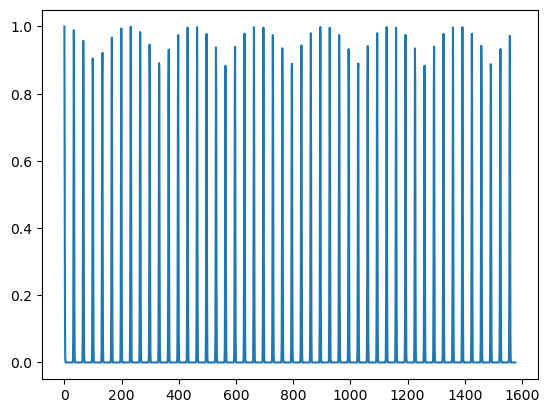

In [17]:

dt = 20
noise_factor = 1.0
data_injection=generate_template(1134944.869275098, 29.489999547765798, 0.0007380463140752472, .22865665220266215, dt=dt)
plt.plot(data_injection)
print(f'Chi squared is {chi_squared(data_injection, data_injection, dt, noise_factor=1.0)}')
print(f'SNR is {np.sqrt(2*chi_squared(data_injection, data_injection, dt, noise_factor=1.0))}' )


In [20]:

prior = ProbDistContainer({
    0: uniform_dist(1133944.869275098, 1135944.869275098),  #M1
    1: uniform_dist(24.489999547765798, 34.489999547765798),   #M2
    2: uniform_dist(0.0003,0.001),   #  f1_measured
    3: uniform_dist(0.2, 0.3),  # eccentricity
})
nwalkers = 20
ndim = 4   #2
sampler = EnsembleSampler(nwalkers, ndim, partial(chi_squared_wrapper, data=data_injection, dt=dt, noise_factor=noise_factor), prior)


start_point = prior.rvs(size=(1, nwalkers, 1))
start_state = State(start_point)

print(start_point.shape)

end_point = sampler.run_mcmc(start_state, 1000, progress=True)

(1, 20, 1, 4)


100%|██████████| 1000/1000 [17:05<00:00,  1.03s/it]


In [37]:
c = sampler.get_chain()['model_0']
post_m1 = c[:,0,:,0,0].reshape([-1])
post_m2 = c[:,0,:,0,1].reshape([-1])
post_f1 = c[:,0,:,0,2].reshape([-1])
post_e = c[:,0,:,0,3].reshape([-1])

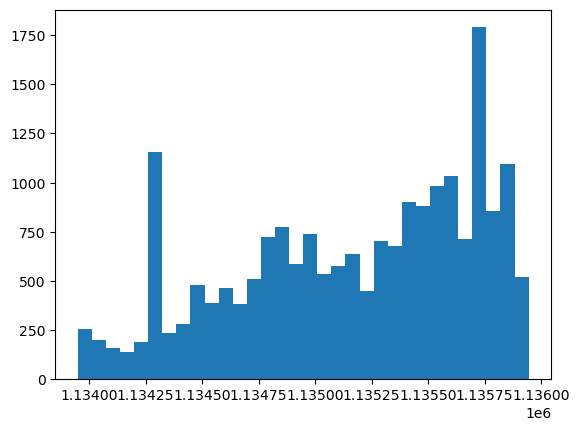

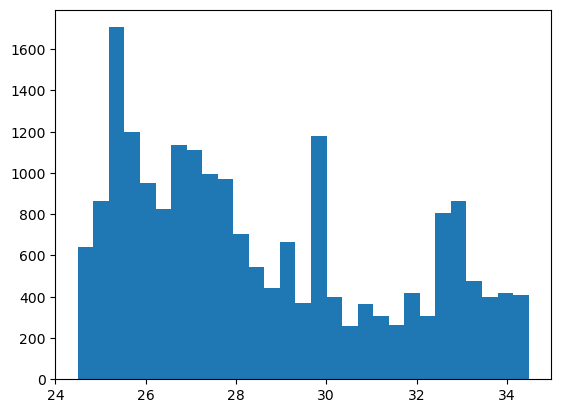

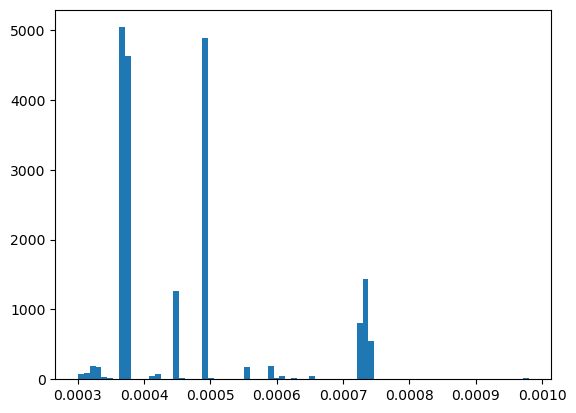

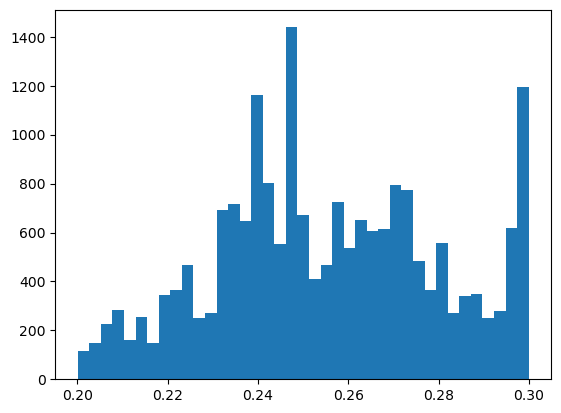

In [40]:
plt.hist(post_m1,bins='auto');
plt.show()
plt.hist(post_m2,bins='auto');
plt.show()

plt.hist(post_f1,bins='auto');
plt.show()
plt.hist(post_e,bins='auto');
plt.show()

'\n# can I make a corner plot\nfrom chainconsumer import ChainConsumer\ndef corner_plot(samples,param_names, outdir="."):\n    c = ChainConsumer()\n    c.add_chain(samples, parameters=param_names, color=\'orange\')\n    c.configure(bar_shade=True, plot_hists=False)\n    fig = c.plotter.plot(figsize=(4, 4))\n    plt.savefig(os.path.join(outdir, f"corner.png"))\n    plt.close()\n\nparam_names = ["M1","m2","f1","e"]\nyay = corner_plot(sampler,param_names)\n'

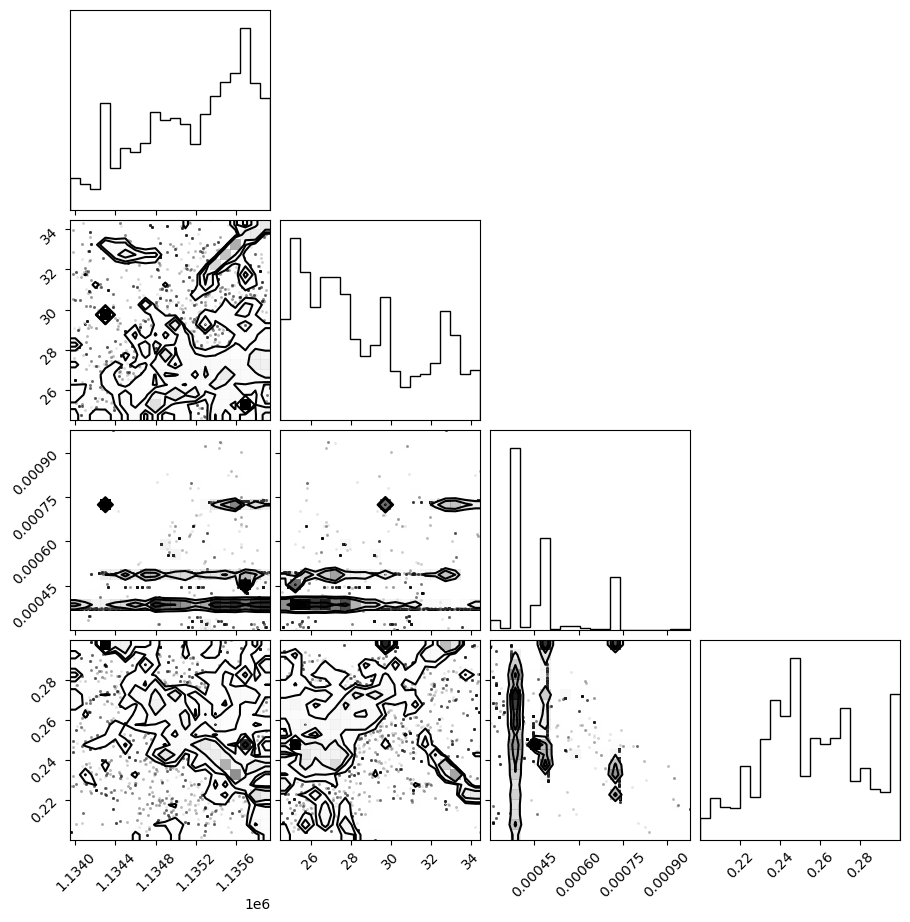

In [46]:
out = sampler.get_chain()['model_0'].reshape(-1, ndim)
import corner
corner.corner(out)

"""
# can I make a corner plot
from chainconsumer import ChainConsumer
def corner_plot(samples,param_names, outdir="."):
    c = ChainConsumer()
    c.add_chain(samples, parameters=param_names, color='orange')
    c.configure(bar_shade=True, plot_hists=False)
    fig = c.plotter.plot(figsize=(4, 4))
    plt.savefig(os.path.join(outdir, f"corner.png"))
    plt.close()

param_names = ["M1","m2","f1","e"]
yay = corner_plot(sampler,param_names)
"""

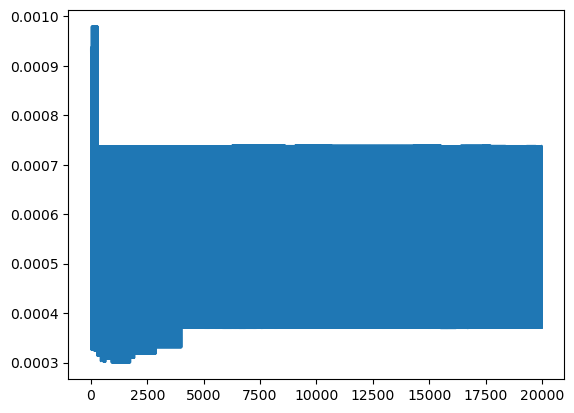

In [53]:
plt.plot(out[:,2])


(1000, 1, 20)


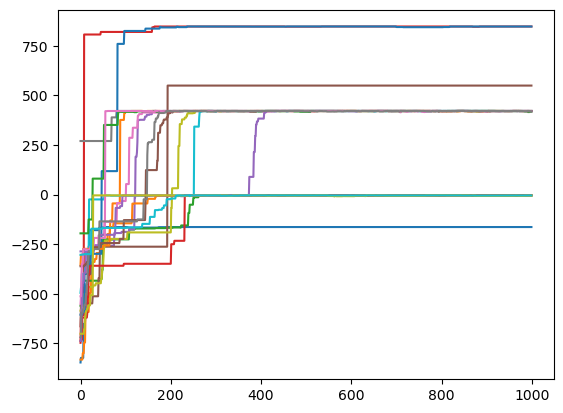

In [57]:
print(sampler.get_log_like().shape)
plt.plot(sampler.get_log_like()[:,0,:])

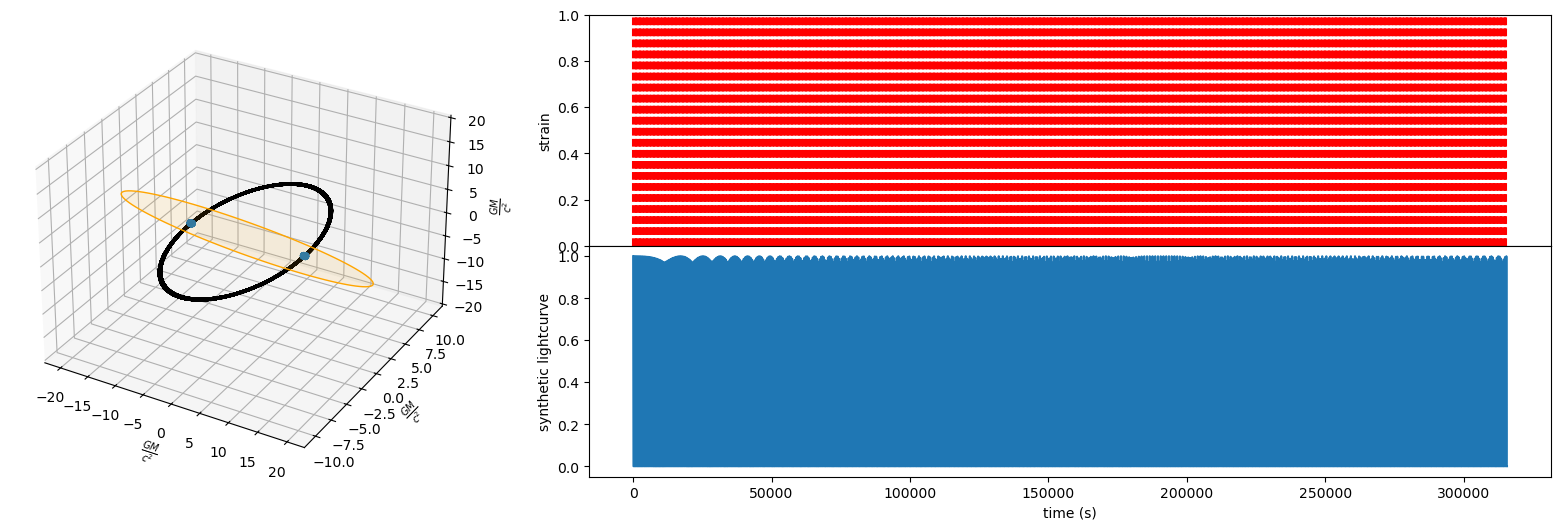

In [15]:
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 2], hspace=0, wspace=0.15)

# Top-right subplot (2D)
ax1 = fig.add_subplot(gs[0, 1])
plt.setp(ax1.get_xticklabels(), visible=False)
# Bottom-right subplot (2D), sharing the x-axis with ax1
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
# Left subplot spanning both rows, set up as a 3D projection
ax3 = fig.add_subplot(gs[:, 0], projection='3d')

# Plot on ax1 (top-right)
ax1.set_ylabel("strain")
for tt in intersections.T[0]:
    ax1.axvline(tt, color='red', linestyle='--')

# Plot on ax2 (bottom-right)
ax2.set_ylabel('synthetic lightcurve')
ax2.set_xlabel('time (s)')
ax2.plot(trajectory[0], lightcurve)

# Plot on ax3 (left, 3D)
plot_inclined_disk(ax3, disk_center0, radius=20, normal=disk_normal0, color='orange', alpha=0.1)
ax3.scatter(*intersections.T[1:])
ax3.plot3D(*trajectory[1:], 'black')
ax3.set_ylabel(r"$ \frac{GM}{c^2}$")
ax3.set_xlabel(r"$ \frac{GM}{c^2}$")
ax3.set_zlabel(r"$ \frac{GM}{c^2}$")

plt.subplots_adjust(hspace=0)
plt.savefig("EM_EMRI.pdf",bbox_inches='tight', pad_inches=0)
plt.show()